In [21]:
import math
import sys
import xml.sax

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from xml.sax.handler import ContentHandler
from typing import Dict, List, Tuple
from scipy import stats

sns.set()

In [22]:
class EdgeDataReader(ContentHandler):
    def __init__(self):
        self._begin: float = 0.0
        self._end: float = 0.0
        self._data: List[Dict] = []

    def startElement(self, name, attrs):
        if name == "interval":
            self._begin = float(attrs["begin"])
            self._end = float(attrs["end"])
            return
        
        if name == "edge":
            self._data.append({
                "edge_id": attrs["id"],
                "begin":   int(self._begin),
                "end":     int(self._end),
                "entered": int(attrs.get("entered", 0)),
                "left":    int(attrs.get("left", 0)),
                "speed":   float(attrs.get("speed", np.nan)),
            })
            return

In [23]:
file_a = "file:///data/src/ITSC2020_CAV_impact/National/Results/Scenario A/edgedata.out.xml"
file_b = "file:///data/src/veins/examples/2_n7/results/20200722162822/edgedata.out.xml"
file_c = "file:///data/src/ITSC2020_CAV_impact/National/Results/Scenario F/edgedata.out.xml" # 100% CAV from G&D, 2020

r = EdgeDataReader()
xp = xml.sax.make_parser()
xp.setContentHandler(r)
xp.parse(file_a)
data_a = deepcopy(r._data)
r._data = []
xp.parse(file_b)
data_b = deepcopy(r._data)
r._data = []
xp.parse(file_c)
data_c = deepcopy(r._data)
r._data = []

df_a = pd.DataFrame(data_a).replace(np.inf, np.nan)
df_b = pd.DataFrame(data_b).replace(np.inf, np.nan)
df_c = pd.DataFrame(data_c).replace(np.inf, np.nan)

DATASETS = {
    "G&D 2020 Scenario A": df_a,
    "Reproduction of G&D 2020 Scenario A": df_b,
    "G&D 2020 Scenario F": df_c,
}

In [24]:
from itertools import combinations

def do_comparison(datasets, attrs=["entered", "left", "speed"], p=0.05):
    html = []
    pairs = combinations(datasets.items(), r=2)
    for pair in pairs:
        (a_name, a_data), (b_name, b_data) = pair
        for attr in attrs:
            sr = stats.ks_2samp(a_data[attr], b_data[attr])
            do_or_dont = "do" if sr.pvalue <= p else "do not"
            fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
            axes[0].set_title(f"A")
            axes[1].set_title(f"B")
            fig.suptitle(f"{a_name} (A) and {b_name} (B) {do_or_dont} differ significantly by {attr}")
            fig.text(s=f"statistic={sr.statistic:.3f} pvalue={sr.pvalue:.3f} (two-tailed)", x=0, y=0)
            sns.distplot(a_data[attr].dropna(), ax=axes[0])
            sns.distplot(b_data[attr].dropna(), ax=axes[1])


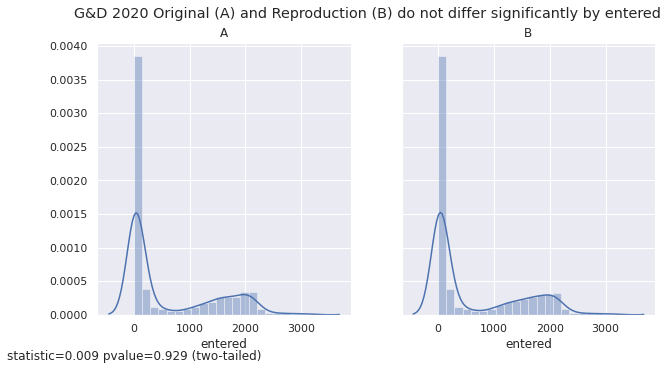

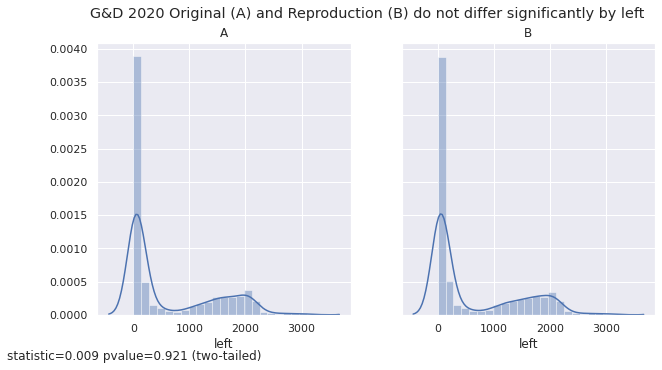

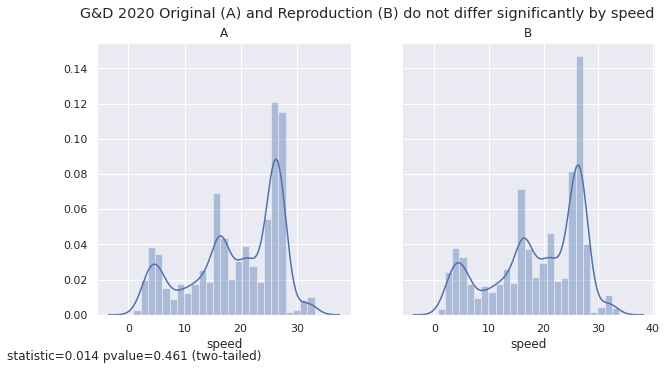

In [25]:
do_comparison({"G&D 2020 Original": df_a, "Reproduction": df_b})

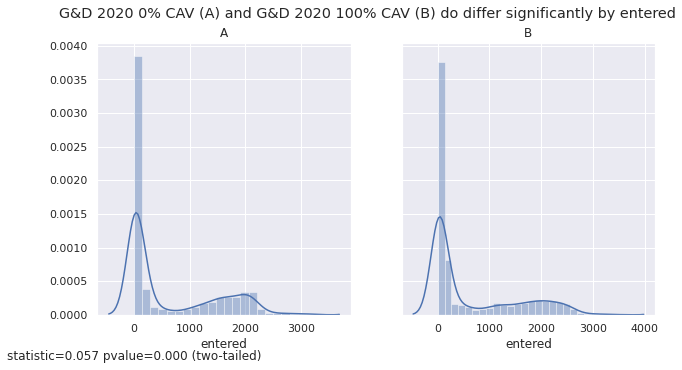

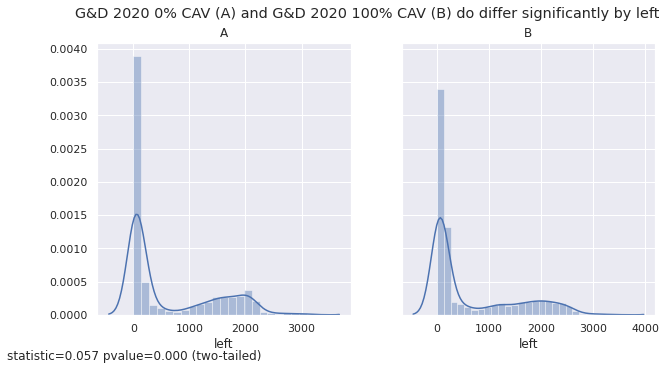

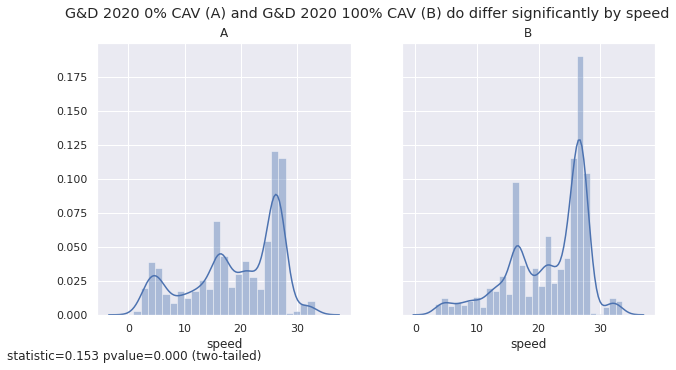

In [26]:
do_comparison({"G&D 2020 0% CAV": df_a, "G&D 2020 100% CAV": df_c})